In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

!ls /content/gdrive/MyDrive/aidea_aso
!cp /content/gdrive/MyDrive/aidea_aso/submission.csv ./
!unzip -q /content/gdrive/MyDrive/aidea_aso/train.zip
!mv images train_images
!mkdir train_20210106
!unzip -q /content/gdrive/MyDrive/aidea_aso/train_20210106.zip -d train_20210106
!unzip -q /content/gdrive/MyDrive/aidea_aso/test.zip
!mv images test_images
!mkdir model

Mounted at /content/gdrive
submission.csv	train_20210106	    train_old  動態足壓影像辨識-報告格式.docx
test.zip	train_20210106.zip  train.zip


In [2]:
!pip install pytorch-lightning --quiet
!pip install -U albumentations --quiet
!echo ---
!ls
!echo ---
!ls train_20210106

     |████████████████████████████████| 839kB 19.0MB/s 
     |████████████████████████████████| 184kB 55.8MB/s 
     |████████████████████████████████| 276kB 50.8MB/s 
     |████████████████████████████████| 112kB 60.4MB/s 
     |████████████████████████████████| 829kB 55.9MB/s 
     |████████████████████████████████| 1.3MB 51.5MB/s 
     |████████████████████████████████| 296kB 55.4MB/s 
     |████████████████████████████████| 143kB 59.3MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 952kB 19.6MB/s 
     |████████████████████████████████| 37.6MB 72kB/s 
---
annotation.csv	model	     test_images     train_images
gdrive		sample_data  train_20210106
---
annotation.csv	images


In [3]:
!ls train_20210106

annotation.csv	images


In [4]:
# Set the path to save PyTorch model
MODEL_SAVE_PATH = '/content/gdrive/MyDrive/aidea_aso_model/'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import cv2
import random
from skimage import io, transform
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision import transforms, utils, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
MODEL_SAVE_PATH = Path(MODEL_SAVE_PATH)
%matplotlib inline

In [23]:
# combine new and old train data
def get_new_file_name(file_name):
    file_name = file_name.split('.')
    assert len(file_name) == 2
    return file_name[0] + "_1" + "." + file_name[1]

new_data_path = Path('train_20210106')
dest_data_path = Path('train_images')
for p in (new_data_path / 'images').glob('image_*'):
    p.rename(Path(dest_data_path, get_new_file_name(p.name)))
print(len(list(dest_data_path.glob('image_*'))))

new_annotation_df = pd.read_csv(new_data_path / "annotation.csv")
dest_annotation_df = pd.read_csv("annotation.csv")
new_annotation_df['images'] = new_annotation_df['images'].apply(get_new_file_name)
annotation_df = pd.concat([dest_annotation_df, new_annotation_df], ignore_index = True)

test_data_path = Path('test_images')
test_image_names = sorted([p.name for p in test_data_path.glob('image_*')])
test_annotation_df = pd.DataFrame({'images': test_image_names})

# find black dots for train set
def find_black_dot(img):
    ## 注意回傳要是 j, i、不是 i, j
    ## 黑點大小 10 * 10
    ## 要找 8*8 都是黑色的點
    kernel = np.ones((8, 8), dtype="float")
    BLACK_THR = 20
    KERNAL_THR = 2.2*5*5 + 1.5*(8*8-5*5)
    img_black = np.sum(img <= BLACK_THR, axis = 2)
    img_filtered = cv2.filter2D(img_black, 1, kernel)
    img_dot_mask = img_filtered >= KERNAL_THR
    dot_i, dot_j = np.where(img_dot_mask)
    dot_i, dot_j = int(np.median(dot_i)), int(np.median(dot_j))
    return (dot_j, dot_i)

dot_list = [find_black_dot(io.imread(dest_data_path / f)) for f in annotation_df.images]
dot_list_trans = list(zip(*dot_list))
annotation_df['dot_x'] = dot_list_trans[0]
annotation_df['dot_y'] = dot_list_trans[1]
print(annotation_df.head())
print()
# find black dots for test set
print(len(test_image_names))
dot_list = [find_black_dot(io.imread(test_data_path / f)) for f in test_image_names]
dot_list_trans = list(zip(*dot_list))
test_annotation_df['dot_x'] = dot_list_trans[0]
test_annotation_df['dot_y'] = dot_list_trans[1]
print(test_annotation_df.head())

1424
           images  x1   y1  x2   y2  dot_x  dot_y
0  image_0001.png  55  136  75  383     52    275
1  image_0002.png  62  139  42  385     67    286
2  image_0003.png  47  117  76  368     52    254
3  image_0004.png  66  119  37  376     65    246
4  image_0005.png  58  147  85  381     54    276

1000
           images  dot_x  dot_y
0  image_0001.png     58    282
1  image_0002.png     59    279
2  image_0003.png     52    292
3  image_0004.png     65    275
4  image_0005.png     55    267


In [24]:
# 120 * 400 * 3
X_CROP_LOWER, X_CROP_UPPER = (3, 8) # 120
Y_CROP_LOWER, Y_CROP_UPPER = (79, 5) # 400
# note: width of upper and lower should logically be the same
split_crop = {
    'upper': {'x': X_CROP_LOWER, 'y': Y_CROP_LOWER, 'width': 120-X_CROP_LOWER-X_CROP_UPPER, 'height': 120},
    'lower': {'x': X_CROP_LOWER, 'y': 400-Y_CROP_UPPER-75, 'width': 120-X_CROP_LOWER-X_CROP_UPPER, 'height': 95}
}
assert split_crop['upper']['width'] == split_crop['lower']['width']

def check_annotation_range(x1, y1, x2, y2):
    # upper box check
    b = x1 < split_crop['upper']['x'] + split_crop['upper']['width']
    b = b and x1 > split_crop['upper']['x']
    b = b and y1 < split_crop['upper']['y'] + split_crop['upper']['height']
    b = b and y1 > split_crop['upper']['y']
    # lower box check
    b = b and x2 < split_crop['lower']['x'] + split_crop['lower']['width']
    b = b and x2 > split_crop['lower']['x']
    b = b and y2 < split_crop['lower']['y'] + split_crop['lower']['height']
    b = b and y2 > split_crop['lower']['y']
    return b

assert annotation_df['x1'].max() < split_crop['upper']['x'] + split_crop['upper']['width']
assert annotation_df['x1'].min() > split_crop['upper']['x']
assert annotation_df['y1'].max() < split_crop['upper']['y'] + split_crop['upper']['height']
assert annotation_df['y1'].min() > split_crop['upper']['y']
assert annotation_df['x2'].max() < split_crop['lower']['x'] + split_crop['lower']['width']
assert annotation_df['x2'].min() > split_crop['lower']['x']
assert annotation_df['y2'].max() < split_crop['lower']['y'] + split_crop['lower']['height']
assert annotation_df['y2'].min() > split_crop['lower']['y']

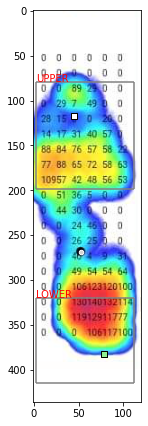

In [25]:
def show_foot(image: np.ndarray, annotations: dict=None, predictions: dict=None, black_dot: dict=None, split_crop: dict=None):
    """Show image with landmarks"""
    """split_crop: {'upper': {'x': int, 'y': int, 'width': int, 'height': int}, 'lower': {'x': int, 'y': int, 'width': int, 'height': int}}"""
    plt.figure(figsize = (6.4*1.5,4.8*1.5))
    plt.imshow(image)
    if annotations:
        plt.scatter(annotations['x1'], annotations['y1'], s=30, marker='s', c='white', edgecolors='black')
        plt.scatter(annotations['x2'], annotations['y2'], s=30, marker='s', c='lightgreen', edgecolors='black')
    if predictions:
        if predictions.get('upper') is not None:
            plt.scatter(predictions['upper'][0], predictions['upper'][1], s=15, marker='s', c='gold', edgecolors='black')
        if predictions.get('lower') is not None:
            plt.scatter(predictions['lower'][0], predictions['lower'][1], s=15, marker='s', c='gold', edgecolors='black')
    if black_dot:
        plt.scatter(black_dot['dot_x'], black_dot['dot_y'], s=20, marker='o', c='lightgrey', edgecolors='white')
    if split_crop:
        plt.hlines(y = split_crop['upper']['y'],
              xmin = split_crop['upper']['x'],
              xmax = split_crop['upper']['x'] + split_crop['upper']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.hlines(y = split_crop['upper']['y'] + split_crop['upper']['height'],
              xmin = split_crop['upper']['x'],
              xmax = split_crop['upper']['x'] + split_crop['upper']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['upper']['x'],
              ymin = split_crop['upper']['y'],
              ymax = split_crop['upper']['y'] + split_crop['upper']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['upper']['x'] + split_crop['upper']['width'],
              ymin = split_crop['upper']['y'],
              ymax = split_crop['upper']['y'] + split_crop['upper']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.text(x = split_crop['upper']['x'], y = split_crop['upper']['y'], s = 'UPPER', color = 'red')
        #
        plt.hlines(y = split_crop['lower']['y'],
              xmin = split_crop['lower']['x'],
              xmax = split_crop['lower']['x'] + split_crop['lower']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.hlines(y = split_crop['lower']['y'] + split_crop['lower']['height'],
              xmin = split_crop['lower']['x'],
              xmax = split_crop['lower']['x'] + split_crop['lower']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['lower']['x'],
              ymin = split_crop['lower']['y'],
              ymax = split_crop['lower']['y'] + split_crop['lower']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['lower']['x'] + split_crop['lower']['width'],
              ymin = split_crop['lower']['y'],
              ymax = split_crop['lower']['y'] + split_crop['lower']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.text(x = split_crop['lower']['x'], y = split_crop['lower']['y'], s = 'LOWER', color = 'red')
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

{'image_0980.png',}
img_name = 'image_0083.png'
img_annotation = annotation_df[annotation_df.images == img_name].to_dict('records')[0]
show_foot(
    io.imread(Path('train_images') / img_name), 
    annotations = img_annotation,
    black_dot = img_annotation,
    split_crop = split_crop
    )

{'images': 'image_0201_1.jpg', 'x1': 62, 'y1': 154, 'x2': 86, 'y2': 382, 'dot_x': 54, 'dot_y': 287}
(400, 120, 3)


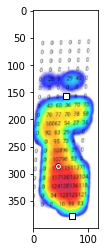

In [27]:
def _translate_mask(mask):
    mask_y = np.where(mask)[0]
    mask_x = np.where(mask)[1]
    if len(mask_x) == 0 or len(mask_y) == 0:
        return None
    else:
        return (mask_x.mean(), mask_y.mean())
def elastic(img, annot, dot, pred_lower=None):
    has_pred_lower = pred_lower is not None
    height, width = img.shape[:2]
    mask1 = np.zeros((*img.shape[:2], 1))
    mask1[int(round(annot[0][1])), int(round(annot[0][0]))] = 1
    mask2 = np.zeros((*img.shape[:2], 1))
    mask2[int(round(annot[1][1])), int(round(annot[1][0]))] = 1
    mask_dot = np.zeros((*img.shape[:2], 1))
    mask_dot[int(round(dot[1])), int(round(dot[0]))] = 1
    img_ori = np.array(img, copy=True)
    mask1_ori = np.array(mask1, copy=True)
    mask2_ori = np.array(mask2, copy=True)
    mask_dot_ori = np.array(mask_dot, copy=True)
    if has_pred_lower:
        mask3 = np.zeros((*img.shape[:2], 1))
        mask3[int(round(pred_lower[1])), int(round(pred_lower[0]))] = 1
        mask3_ori = np.array(mask3, copy=True)
    # Random affine
    center_square = np.float32((height, width)) // 2
    square_size = min((height, width)) // 3
    pts1 = np.float32(
        [
            center_square + square_size,
            [center_square[0] + square_size, center_square[1] - square_size],
            center_square - square_size,
        ]
    )
    if_retry = True
    while if_retry:
        img = np.array(img_ori, copy=True)
        mask1 = np.array(mask1_ori, copy=True)
        mask2 = np.array(mask2_ori, copy=True)
        mask_dot = np.array(mask_dot_ori, copy=True)
        if has_pred_lower:
            mask3 = np.array(mask3_ori, copy=True)
        alpha_affine = float(random.random()*15)
        pts2 = pts1 + np.random.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        matrix = cv2.getAffineTransform(pts1, pts2)
        img = cv2.warpAffine(img,
            M=matrix, dsize=(width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
        )
        mask1 = cv2.warpAffine(mask1,
            M=matrix, dsize=(width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
        )
        mask2 = cv2.warpAffine(mask2,
            M=matrix, dsize=(width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
        )
        if has_pred_lower:
            mask3 = cv2.warpAffine(mask3,
                M=matrix, dsize=(width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
            )
            mask3 = _translate_mask(mask3)
            if mask3 is None:
                continue
        mask_dot = cv2.warpAffine(mask_dot,
            M=matrix, dsize=(width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
        )
        mask1 = _translate_mask(mask1)
        mask2 = _translate_mask(mask2)
        mask_dot = _translate_mask(mask_dot)
        if mask1 is None or mask2 is None or mask_dot is None:
            continue
        else:
            if_retry = False
        new_x1, new_y1 = mask1
        new_x2, new_y2 = mask2
        new_dot_x, new_dot_y = mask_dot
        if has_pred_lower:
            new_pred_lower_x, new_pred_lower_y = mask3
            new_pred_lower = np.array([new_pred_lower_x, new_pred_lower_y]).astype('float')
        else:
            new_pred_lower = None
    return img, np.array([[new_x1, new_y1], [new_x2, new_y2]]).astype('float'), np.array([new_dot_x, new_dot_y]).astype('float'), new_pred_lower

img_name = 'image_0201_1.jpg'
img_annotation = annotation_df[annotation_df.images == img_name].to_dict('records')[0]
print(img_annotation)
img = io.imread(Path('train_images') / img_name)
img, annot, dot, pred_lower = elastic(img, np.array([[img_annotation['x1'], img_annotation['y1']], [img_annotation['x2'], img_annotation['y2']]]), np.array([img_annotation['dot_x'], img_annotation['dot_y']]))

print(img.shape)
plt.imshow(img)
plt.scatter(annot[:,0], annot[:,1], s=30, marker='s', c='white', edgecolors='black')
plt.scatter(dot[0], dot[1], s=15, marker='o', c='red', edgecolors='white')
plt.show()

{'images': 'image_0203_1.jpg', 'x1': 83, 'y1': 122, 'x2': 75, 'y2': 368, 'dot_x': 62, 'dot_y': 268}


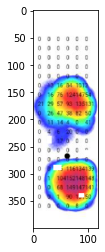

In [28]:
trafo = A.CoarseDropout(always_apply=True, max_height=15, max_width=15, min_height=6, min_width=6, min_holes=3, max_holes=10, fill_value=(255,255,255))
img_name = 'image_0203_1.jpg'
img_annotation = annotation_df[annotation_df.images == img_name].to_dict('records')[0]
print(img_annotation)
img = io.imread(Path('train_images') / img_name)
img_trafo = trafo(image=img)['image']
plt.imshow(img_trafo)

In [29]:
# Move, Rotate, Scale up / down
# 平移

def move_points(points, param):
    M = np.float32([[1,0,param['X_MOVE']], [0,1,param['Y_MOVE']]])
    if points.shape == (2,):
        points = np.transpose(np.concatenate((points, np.array([1])), axis=0))
    elif points.shape == (2,2):
        points = np.transpose(np.concatenate((points, np.array([[1], [1]])), axis=1))
    else:
        print('unknown shape in `move_points`')
        raise RuntimeError 
    points = np.transpose(np.matmul(M, points)[:2])
    return points

def move_image(img, param):
    M = np.float32([[1,0,param['X_MOVE']], [0,1,param['Y_MOVE']]])
    if random.random() < 0.5:
        img = cv2.warpAffine(img, M, dsize=(120, 400), borderValue=(255,255,255))
    else:
        img = cv2.warpAffine(img, M, dsize=(120, 400), borderMode=cv2.BORDER_REPLICATE)
    return img

# 旋轉 (以 dot 為中心)

def rotate_points(points, dot, param):
    M = cv2.getRotationMatrix2D((dot[0], dot[1]), param['ANGLE'], 1)
    if points.shape == (2,):
        points = np.transpose(np.concatenate((points, np.array([1])), axis=0))
    elif points.shape == (2,2):
        points = np.transpose(np.concatenate((points, np.array([[1], [1]])), axis=1))
    else:
        print('unknown shape in `rotate_points`')
        raise RuntimeError 
    points = np.transpose(np.matmul(M, points)[:2])
    return points

def rotate_image(img, dot, param):
    M = cv2.getRotationMatrix2D((dot[0], dot[1]), param['ANGLE'], 1)
    if random.random() < 0.5:
        img = cv2.warpAffine(img, M, dsize=(120, 400), borderValue=(255,255,255))
    else:
        img = cv2.warpAffine(img, M, dsize=(120, 400), borderMode=cv2.BORDER_REPLICATE)
    return img

# 縮放
## 放大 = 先 crop 再放大

def scale_up_points(points, param):
    points = points - np.array([param['NEW_ORI_X'], param['NEW_ORI_Y']])
    points = points * np.array([param['PROP_X'], param['PROP_Y']])
    return points

def scale_up_image(img, param):
    img = img[param['NEW_ORI_Y']:, param['NEW_ORI_X']:, :]
    img = cv2.resize(img, (120, 400))
    return img

## 縮小 = 先 crop 再縮小再填充

def scale_down_points(points, param):
    points = points - np.array([param['NEW_ORI_X'], param['NEW_ORI_Y']])
    points = points * np.array([param['PROP_X'], param['PROP_Y']])
    points = points + np.array([param['PAD_LEFT'], param['PAD_TOP']])
    return points

def scale_down_image(img, param):
    img = img[param['NEW_ORI_Y']:, param['NEW_ORI_X']:, :]
    img = cv2.resize(img, (param['NEW_WIDTH'], param['NEW_HEIGHT']))
    if random.random() < 0.5:
        img = cv2.copyMakeBorder(img, top=param['PAD_TOP'], bottom=400-param['NEW_HEIGHT']-param['PAD_TOP'], 
                                left=param['PAD_LEFT'], right=120-param['NEW_WIDTH']-param['PAD_LEFT'],
                                borderType=cv2.BORDER_CONSTANT,
                                value=(255,255,255))
    else:
        img = cv2.copyMakeBorder(img, top=param['PAD_TOP'], bottom=400-param['NEW_HEIGHT']-param['PAD_TOP'], 
                                left=param['PAD_LEFT'], right=120-param['NEW_WIDTH']-param['PAD_LEFT'],
                                borderType=cv2.BORDER_REPLICATE)
    return img

In [30]:
# Transform: Move, rotate, scale (up or down)
def _get_param(t):
    param = {}
    if 'move' in t:
        # 平移
        X_MOVE, Y_MOVE = random.randint(-X_CROP_LOWER-10, X_CROP_UPPER+25), random.randint(-45, Y_CROP_UPPER+5)
        param.update({'X_MOVE': X_MOVE, 'Y_MOVE': Y_MOVE})
    if 'rotate' in t:
        # 旋轉
        ANGLE = random.randint(-5, 5)
        param.update({'ANGLE': ANGLE})
    if 'scale_up' in t:
        # 放大
        NEW_ORI_X, NEW_ORI_Y = random.randint(1, X_CROP_LOWER+50), random.randint(1, 70)
        PROP_X, PROP_Y = 120/(120-NEW_ORI_X), 400/(400-NEW_ORI_Y)
        param.update({'NEW_ORI_X': NEW_ORI_X, 'NEW_ORI_Y': NEW_ORI_Y,
                    'PROP_X': PROP_X, 'PROP_Y': PROP_Y})
    elif 'scale_down' in t:
        # 縮小
        NEW_ORI_X, NEW_ORI_Y = random.randint(1, X_CROP_LOWER+35), random.randint(1, 55)
        NEW_WIDTH, NEW_HEIGHT = 120-random.randint(1, X_CROP_UPPER+30)-NEW_ORI_X, 400-random.randint(1, 50)-NEW_ORI_Y
        PROP_X, PROP_Y = NEW_WIDTH/(120-NEW_ORI_X), NEW_HEIGHT/(400-NEW_ORI_Y)
        PAD_LEFT, PAD_TOP = random.randint(0, NEW_ORI_X), random.randint(0, NEW_ORI_Y)
        param.update({'NEW_ORI_X': NEW_ORI_X, 'NEW_ORI_Y': NEW_ORI_Y,
                    'NEW_WIDTH': NEW_WIDTH, 'NEW_HEIGHT': NEW_HEIGHT,
                    'PROP_X': PROP_X, 'PROP_Y': PROP_Y,
                    'PAD_LEFT': PAD_LEFT, 'PAD_TOP': PAD_TOP})
    return param

def _get_trans_list(prob=0.5):
    if random.random() < 0.4:
        return ['elastic']
    TRANS_LIST = ['scale', 'rotate', 'move']
    t = list()
    while len(t) == 0:
        for i in random.sample(range(len(TRANS_LIST)), len(TRANS_LIST)):
            if random.random() >= prob: continue
            if TRANS_LIST[i] == 'scale':
                if random.random() < 0.5:
                    t.append('scale_up')
                else:
                    t.append('scale_down')
            else:
                t.append(TRANS_LIST[i])
    return t

def move_rotate_scale(img, annot, dot, pred_lower=None, prob=0.5):
    t = _get_trans_list(prob)
    has_pred_lower = pred_lower is not None
    if len(t) == 0: 
        if has_pred_lower is False:
            pred_lower = None
        return (img, annot, dot, pred_lower)
    img_ori, annot_ori, dot_ori = np.array(img, copy=True), np.array(annot, copy=True), np.array(dot, copy=True)
    if has_pred_lower:
        pred_lower_ori = np.array(pred_lower, copy=True)
    # get new param and transform annot and dot first
    # if transform not legal, reset param
    while True:
        if_retry = False
        param = _get_param(t)
        
        annot = np.array(annot_ori, copy=True)
        dot = np.array(dot_ori, copy=True)
        if has_pred_lower:
            pred_lower = np.array(pred_lower_ori, copy=True)
        
        for trafo in t:
            if trafo == 'move':
                annot = move_points(annot, param)
                dot = move_points(dot, param)
                if has_pred_lower:
                    pred_lower = move_points(pred_lower, param)
            elif trafo == 'rotate':
                annot = rotate_points(annot, dot, param)
                if has_pred_lower:
                    pred_lower = rotate_points(pred_lower, dot, param)
            elif trafo == 'scale_up':
                annot = scale_up_points(annot, param)
                dot = scale_up_points(dot, param)
                if has_pred_lower:
                    pred_lower = scale_up_points(pred_lower, param)
            elif trafo == 'scale_down':
                annot = scale_down_points(annot, param)
                dot = scale_down_points(dot, param)
                if has_pred_lower:
                    pred_lower = scale_down_points(pred_lower, param)
            elif trafo == 'elastic':
                if has_pred_lower:
                    _pred_lower = pred_lower
                else:
                    _pred_lower = None
                img_elastic, annot, dot, pred_lower = elastic(img, annot, dot, _pred_lower)
            else:
                print('warning: unknown transformation')
    
            if not check_annotation_range(annot[0][0], annot[0][1], annot[1][0], annot[1][1]):
                if_retry = True
                break
            if has_pred_lower and not check_annotation_range(annot[0][0], annot[0][1], pred_lower[0], pred_lower[1]):
                if_retry = True
                break
        if not if_retry: break
    
    # transform image (only if trafo legal)
    img = np.array(img_ori, copy=True)
    for trafo in t:
        if trafo == 'move':
            img = move_image(img, param)
        elif trafo == 'rotate':
            img = rotate_image(img, dot, param)
        elif trafo == 'scale_up':
            img = scale_up_image(img, param)
        elif trafo == 'scale_down':
            img = scale_down_image(img, param)
        elif trafo == 'elastic':
            img = img_elastic
        else:
            print('warning: unknown transformation')
    if has_pred_lower is False:
        pred_lower = None
    return (img, annot, dot, pred_lower)

class MoveRotateScale():
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, sample):
        if random.random() >= self.prob: return sample
        file_name, image, dot, annotations = sample['file_name'], sample['image'], sample['dot'], sample['annotations']
        pred_lower = sample.get('pred_lower')
        image, annotations, dot, pred_lower = move_rotate_scale(image, annotations, dot, pred_lower, prob=0.6)
        sample = {'file_name': file_name, 'image': image, 'annotations': annotations, 'dot': dot}
        if pred_lower is not None:
            sample['pred_lower'] = pred_lower
        return sample

In [31]:
# Transformations
# split_crop: {'upper': {'x': int, 'y': int, 'width': int, 'height': int}, 'lower': {'x': int, 'y': int, 'width': int, 'height': int}}

def split_crop_image(img):
    return {
        'upper': img[split_crop['upper']['y']:(split_crop['upper']['y']+split_crop['upper']['height']),
                     split_crop['upper']['x']:(split_crop['upper']['x']+split_crop['upper']['width']), :],
        'lower': img[split_crop['lower']['y']:(split_crop['lower']['y']+split_crop['lower']['height']),
                     split_crop['lower']['x']:(split_crop['lower']['x']+split_crop['lower']['width']), :]
    }

def split_crop_annotation(x1, y1, x2, y2):
    upper = np.array([x1-split_crop['upper']['x'], y1-split_crop['upper']['y']]).astype('float')
    lower = np.array([x2-split_crop['lower']['x'], y2-split_crop['lower']['y']]).astype('float')
    return {'upper': upper, 'lower': lower}

def split_crop_dot(x, y):
    return np.array([x-split_crop['upper']['x'], y-split_crop['upper']['y']]).astype('float')

def normalize_image(img):
    return {'upper': img['upper'] / 255, 'lower': img['lower'] / 255}

def normalize_dot(x, y):
    H = split_crop['lower']['y'] - split_crop['upper']['y'] + split_crop['lower']['height']
    W = split_crop['upper']['width']
    return np.array([x / W, y / H])

def normalize_annotation(annotations):
    return {
        'upper': annotations['upper'] / np.array([split_crop['upper'][k] for k in ['width', 'height']]),
        'lower': annotations['lower'] / np.array([split_crop['lower'][k] for k in ['width', 'height']]),
    }

def flip_dot_horizontal(x, y):
    return np.array([abs(x - split_crop['upper']['width']), y])

def flip_annotation_horizontal(annotations):
    return {
        'upper': np.abs(np.array([split_crop['upper']['width'], 0]) - annotations['upper']),
        'lower': np.abs(np.array([split_crop['lower']['width'], 0]) - annotations['lower'])
    }

def interpret_output(out):
    out_upper, out_lower = out.get('upper'), out.get('lower')
    # reverse normalization
    # reverse crop
    if out_upper:
        out_upper = out_upper * np.array([split_crop['upper'][k] for k in ['width', 'height']])
        out_upper = out_upper + np.array([split_crop['upper']['x'], split_crop['upper']['y']])
    if out_lower:
        out_lower = out_lower * np.array([split_crop['lower'][k] for k in ['width', 'height']])
        out_lower = out_lower + np.array([split_crop['lower']['x'], split_crop['lower']['y']])
    result = {'upper': (round(out_upper[0], 4), round(out_upper[1], 4)) if out_upper is not None else None,
              'lower': (round(out_lower[0], 4), round(out_lower[1], 4)) if out_lower is not None else None}
    return result

class SplitCrop():
    def __init__(self):
        pass
    
    def __call__(self, sample):
        file_name, image, dot, annotations = sample['file_name'], sample['image'], sample['dot'], sample.get('annotations')
        pred_lower = sample.get('pred_lower')
        image = split_crop_image(image)

        sample = {'file_name': file_name, 'image': image, 'dot': split_crop_dot(dot[0], dot[1])}
        if annotations is not None:
            new_annotations = split_crop_annotation(
                **{'x1': annotations[0][0], 'y1': annotations[0][1],
                  'x2': annotations[1][0], 'y2': annotations[1][1]}
                )
            sample['annotations'] = new_annotations
        if pred_lower is not None:
            sample['pred_lower'] = split_crop_annotation(0, 0, pred_lower[0], pred_lower[1])['lower']
        return sample

class Normalize():
    def __init__(self):
        pass

    def __call__(self, sample):
        file_name, image, dot, annotations = sample['file_name'], sample['image'], sample['dot'], sample.get('annotations')
        pred_lower = sample.get('pred_lower')
        image = normalize_image(image)

        sample = {'file_name': file_name, 'image': image, 'dot': normalize_dot(dot[0], dot[1])}
        if annotations is not None:
            sample['annotations'] = normalize_annotation(annotations)
        if pred_lower is not None:
            sample['pred_lower'] = normalize_annotation({'upper': np.array([0., 0.]), 'lower': pred_lower})['lower']
        return sample

def reduce_noise(image, if_test=False):
    THR = 300
    BLUR = 13
    image_bool = np.logical_and((image.max(axis=2) - np.median(image, axis=2) < THR), (np.median(image, axis=2) - image.min(axis=2) < THR))
    image_bool_mask = np.repeat(image_bool[:, :, np.newaxis], repeats=3, axis=2)
    blurred_image = cv2.medianBlur(image, BLUR)
    transformed_image = np.where(image_bool_mask, blurred_image, image)
    return transformed_image

class RandomReduceNoise():
    def __init__(self, prob=1.0, if_test=False):
        self.prob = prob
        self.if_test = if_test
    
    def __call__(self, sample):
        file_name, image, dot, annotations = sample['file_name'], sample['image'], sample['dot'], sample.get('annotations')
        pred_lower = sample.get('pred_lower')
        if self.if_test:
            image = reduce_noise(image, if_test=True)
        elif random.random() < self.prob:
            image = reduce_noise(image)
        
        sample = {'file_name': file_name, 'image': image, 'dot': dot}
        if annotations is not None:
            sample['annotations'] = annotations
        if pred_lower is not None:
            sample['pred_lower'] = pred_lower
        return sample

class RandomHorizontalFlip():
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, sample):
        file_name, image, dot, annotations = sample['file_name'], sample['image'], sample['dot'], sample['annotations']
        pred_lower = sample.get('pred_lower')
        if random.random() < self.prob:
            image = {k: cv2.flip(v, 1) for k, v in image.items()}
            dot = flip_dot_horizontal(dot[0], dot[1])
            annotations = flip_annotation_horizontal(annotations)
            if pred_lower is not None:
                pred_lower = flip_annotation_horizontal({'upper': np.array([0., 0.]), 'lower': pred_lower})['lower']
        sample = {'file_name': file_name, 'image': image, 'dot': dot, 'annotations': annotations}
        if pred_lower is not None:
            sample['pred_lower'] = pred_lower
        return sample

class RandomCoarseDropout():
    def __init__(self, prob=0.5):
        self.prob = prob
        self.trafo = A.CoarseDropout(always_apply=True, max_height=17, max_width=17, min_height=6, min_width=6, min_holes=5, max_holes=10, fill_value=(255,255,255))
    
    def __call__(self, sample):
        file_name, image, dot, annotations = sample['file_name'], sample['image'], sample['dot'], sample['annotations']
        pred_lower = sample.get('pred_lower')
        if random.random() < self.prob:
            image = {k: self.trafo(image=v)['image'] for k, v in image.items()}
        sample = {'file_name': file_name, 'image': image, 'dot': dot, 'annotations': annotations}
        if pred_lower is not None:
            sample['pred_lower'] = pred_lower
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        file_name, image, dot, annotations = sample['file_name'], sample['image'], sample['dot'], sample.get('annotations')
        pred_lower = sample.get('pred_lower')
        # swap color channel axis 
        # numpy image: H x W x C
        # torch image: C X H X W
        image = {k: torch.from_numpy(v.transpose((2, 0, 1))).float() for k, v in image.items()}
        sample = {'file_name': file_name, 'image': image, 'dot': torch.from_numpy(dot).float()}
        if annotations is not None:
            sample['annotations'] = {k: torch.from_numpy(v).float() for k, v in annotations.items()}
        if pred_lower is not None:
            sample['pred_lower'] = torch.from_numpy(pred_lower).float()
        return sample



In [32]:
# PyTorch Dataset
train_transform = transforms.Compose([MoveRotateScale(0.85), RandomReduceNoise(prob=1), SplitCrop(), RandomHorizontalFlip(), RandomCoarseDropout(0.6), Normalize(), ToTensor()])
test_transform = transforms.Compose([RandomReduceNoise(if_test=True), SplitCrop(), Normalize(), ToTensor()])

class FeetDataset(Dataset):
    """Feet Annotation dataset."""

    def __init__(self, mode='train', indices=None, transform=None):

        self.if_pred_lower = False
        assert mode in {'train', 'val', 'test'}
        self.mode = mode
        if self.mode in {'train', 'val'}:
            self.annotation_df = annotation_df.copy()
            self.img_dir = Path('train_images')
            REMOVE_FILES = {'image_0980.png', 'image_0749.png', 'image_0751.png', 'image_0147.png', 'image_0747.png', 'image_0649.jpg', 'image_0479.png'}
            img_path_list = [f for f in sorted(list(self.img_dir.glob('image_*'))) if f.name not in REMOVE_FILES]
            self.annotation_df = self.annotation_df[~self.annotation_df['images'].isin(REMOVE_FILES)]
        else:
            self.annotation_df = test_annotation_df.copy()
            self.img_dir = Path('test_images')
            img_path_list = sorted(list(self.img_dir.glob('image_*')))

        if indices:
            self.img_path_list = [img_path_list[i] for i in sorted(indices)]
        else: 
            self.img_path_list = img_path_list
        
        if transform is False:
            self.transform = None
        elif transform is not None:
            self.transform = transform
        else:
            if self.mode == 'train':
                self.transform = train_transform
            else:
                self.transform = test_transform

    def update_file_removal(self, file_list):
        self.img_path_list = [f for f in self.img_path_list if f.name not in file_list]
        self.annotation_df = self.annotation_df[~self.annotation_df['images'].isin(file_list)]

    def add_pred_lower(self, new_annotation_df):
        self.if_pred_lower = True
        self.annotation_df = new_annotation_df.copy()
        if self.mode == 'test':
            assert 'x1' not in self.annotation_df.columns
            assert 'y2' not in self.annotation_df.columns
        assert 'pred_lower_x' in self.annotation_df.columns
        assert 'pred_lower_y' in self.annotation_df.columns

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()[0]
        img_name = self.img_path_list[idx].name
        img_path = self.img_dir / img_name
        img_record = self.annotation_df[self.annotation_df.images == img_name].to_dict('records')[0]
        image = io.imread(img_path)
        sample = {'file_name': img_name, 'image': image, 
                  'dot': np.array([img_record[k] for k in ['dot_x', 'dot_y']])}
        if self.mode in ['train', 'val']:
            annotations = np.array([img_record[k] for k in ['x1', 'y1', 'x2', 'y2']])
            annotations = annotations.astype('float').reshape(-1, 2)
            sample['annotations'] = annotations
        if self.if_pred_lower:
            pred_lower = np.array([img_record[k] for k in ['pred_lower_x', 'pred_lower_y']])
            sample['pred_lower'] = pred_lower
        if self.transform:
            sample = self.transform(sample)

        return sample

In [33]:
BATCH_SIZE = 65
LEARNING_RATE = 0.0005
VAL_SPLIT = .2

RANDOM_SEED= 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
pl.trainer.seed_everything(seed=RANDOM_SEED)

class FeetDataModule(pl.LightningDataModule):

    def __init__(self, batch_size=BATCH_SIZE, val_split=VAL_SPLIT):
        super().__init__()
        self.batch_size = batch_size
        self.val_split = val_split
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.if_train_all_data = False

        dataset_size = len(FeetDataset(mode='train'))
        indices = list(range(dataset_size))
        split = int(np.floor(self.val_split * dataset_size))
        np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        self.all_train_dataset = FeetDataset(mode='train', transform=self.test_transform)
        self.val_dataset = FeetDataset(mode='val', indices=val_indices)
        self.train_dataset = FeetDataset(mode='train', indices=train_indices)
        self.test_dataset = FeetDataset(mode='test')


    def _modify_batch_size(self):
        while (len(self.train_dataset)%self.batch_size<=3) or (len(self.val_dataset)%self.batch_size<=3) or (len(self.test_dataset)%self.batch_size<=3):
            self.batch_size += 1

    def set_if_train_all_data(self, if_train_all_data):
        self.if_train_all_data = self.if_train_all_data

    def all_train_dataloader(self, if_test=True):
        if if_test:
            return DataLoader(self.all_train_dataset, batch_size=self.batch_size, shuffle=False)
        else:
            ds = FeetDataset(mode='train', transform=self.train_transform)
            if self.all_train_dataset.if_pred_lower:
                ds.add_pred_lower(self.all_train_dataset.annotation_df)
            else:
                print("Noticing: `all_train_dataset` hasn't set `pred_lower` yet when asking for `all_train_loader()`")
            return DataLoader(ds, batch_size=self.batch_size, shuffle=True)

    def train_dataloader(self, shuffle=True):
        if self.if_train_all_data:
            print("Noticing: you're training with all data (without val split)")
            return self.all_train_dataloader(if_test=False)
        else:
            return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=shuffle)

    def val_dataloader(self, shuffle=False):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=shuffle)

    def test_dataloader(self, shuffle=False):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=shuffle)

Global seed set to 42


In [34]:
class LowerFeetModel(pl.LightningModule):
    
    def __init__(self, learning_rate=LEARNING_RATE):

        super().__init__()
        self.learning_rate = learning_rate

        resnet18_model = models.resnet34(pretrained=False)
        resnet18_conv = nn.Sequential(*list(resnet18_model.children())[:-2])
        self.lower_conv = resnet18_conv 
        self.lower_fc = nn.Sequential(
            nn.Linear((512*3*4+2), 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def euclidean_distance_loss(self, prediction, ground_truth):
        diff = prediction.view(-1, 2) - ground_truth.view(-1, 2)
        eu_dist = torch.sqrt(torch.sum(torch.pow(diff, 2), dim=1))
        return torch.mean(eu_dist)

    def forward(self, image_lower, dot):
        lower_conv = self.lower_conv(image_lower)
        lower_out = self.lower_fc(torch.cat((self.flatten(lower_conv), dot), 1))
        return lower_out

    def training_step(self, batch, batch_idx):
        image_lower = batch['image']['lower']
        dot = batch['dot']
        annotations_lower = batch['annotations']['lower']

        # Forward pass
        outputs = self.forward(image_lower, dot)
        loss = self.euclidean_distance_loss(outputs, annotations_lower)

        self.log('train_loss', loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        image_lower = batch['image']['lower']
        dot = batch['dot']
        annotations_lower = batch['annotations']['lower']

        # Forward pass
        outputs = self.forward(image_lower, dot)
        loss = self.euclidean_distance_loss(outputs, annotations_lower)
        self.log('val_loss', loss, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)
        # return [optimizer], [scheduler]
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [35]:
TRAIN_LOWER = True
TRAIN_ALL_DATA = False
MODEL_SAVE_NAME = 'my_lower_feet_model_weights'

dm = FeetDataModule()
dm.set_if_train_all_data(TRAIN_ALL_DATA)
model_lower = LowerFeetModel()

if TRAIN_LOWER:
    logger = TensorBoardLogger('tb_logs', name='my_lower_feet_model')
    early_stop_callback = EarlyStopping(
        min_delta=0.00,
        patience=6,
        verbose=False,
        monitor='val_loss',
        mode='min'
    )
    checkpoint_callback = ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename=MODEL_SAVE_NAME,
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    trainer = pl.Trainer(max_epochs=50, 
                        logger=logger, 
                        progress_bar_refresh_rate=20, 
                        gpus=-1 if torch.cuda.is_available() else 0, 
                        auto_lr_find=True,
                        callbacks=[early_stop_callback, checkpoint_callback])
    # trainer.tune(model_lower, dm)
    trainer.fit(model_lower, dm)
    assert checkpoint_callback.best_model_score.item() < 0.034
    model_lower = LowerFeetModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
else:
    print(f"Reuse model: {str(MODEL_SAVE_PATH / MODEL_SAVE_NAME)+'.ckpt'}")
    model_lower = LowerFeetModel.load_from_checkpoint(str(MODEL_SAVE_PATH / MODEL_SAVE_NAME)+'.ckpt')

model_lower.eval()
assert model_lower.training is False

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /content/gdrive/MyDrive/aidea_aso_model exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | lower_conv | Sequential | 21.3 M
1 | lower_fc   | Sequential | 3.2 M 
2 | flatten    | Flatten    | 0     
------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
98.013    Total estimated model params size (MB)


Epoch 0, global step 17: val_loss reached 0.32524 (best 0.32524), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 1, global step 35: val_loss reached 0.07610 (best 0.07610), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 2, global step 53: val_loss reached 0.05760 (best 0.05760), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 3, global step 71: val_loss reached 0.05143 (best 0.05143), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 4, global step 89: val_loss reached 0.04453 (best 0.04453), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 5, step 107: val_loss was not in top 1


Epoch 6, step 125: val_loss was not in top 1


Epoch 7, global step 143: val_loss reached 0.04114 (best 0.04114), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 8, step 161: val_loss was not in top 1


Epoch 9, step 179: val_loss was not in top 1


Epoch 10, global step 197: val_loss reached 0.03759 (best 0.03759), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 11, step 215: val_loss was not in top 1


Epoch 12, step 233: val_loss was not in top 1


Epoch 13, step 251: val_loss was not in top 1


Epoch 14, global step 269: val_loss reached 0.03433 (best 0.03433), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 15, step 287: val_loss was not in top 1


Epoch 16, step 305: val_loss was not in top 1


Epoch 17, step 323: val_loss was not in top 1


Epoch 18, step 341: val_loss was not in top 1


Epoch    19: reducing learning rate of group 0 to 5.0000e-05.


Epoch 19, global step 359: val_loss reached 0.03332 (best 0.03332), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 20, global step 377: val_loss reached 0.03091 (best 0.03091), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_lower_feet_model_weights.ckpt" as top 1


Epoch 21, step 395: val_loss was not in top 1


Epoch 22, step 413: val_loss was not in top 1


Epoch 23, step 431: val_loss was not in top 1


Epoch 24, step 449: val_loss was not in top 1


Epoch    25: reducing learning rate of group 0 to 5.0000e-06.


Epoch 25, step 467: val_loss was not in top 1


Epoch 26, step 485: val_loss was not in top 1


In [36]:
# # Start tensorboard.
# %reload_ext tensorboard
# %tensorboard --logdir tb_logs

In [37]:
# Check the prediction results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_model_lower = model_lower.eval().to(device)

# predict lower foot for all train dataset
my_pred_lower_train = dict()
for i, batch in enumerate(dm.all_train_dataloader()):
    image_lower = batch['image']['lower'].to(device)
    dot = batch['dot'].to(device)

    outputs = my_model_lower(image_lower, dot)
    pred = [interpret_output({'upper': None, 'lower': (x[0], x[1])}) for x in outputs.data.to('cpu').tolist()]
    my_pred_lower_train.update({f: {'pred_lower_x': pred[idx]['lower'][0], 'pred_lower_y': pred[idx]['lower'][1]} for idx, f in enumerate(batch['file_name'])})

In [38]:
# update train and val dataset
df = dm.all_train_dataset.annotation_df.copy()
df['pred_lower_x'] = [my_pred_lower_train[f]['pred_lower_x'] for f in df['images']]
df['pred_lower_y'] = [my_pred_lower_train[f]['pred_lower_y'] for f in df['images']]
print(df.tail())
dm.all_train_dataset.add_pred_lower(df)
dm.train_dataset.add_pred_lower(df)
dm.val_dataset.add_pred_lower(df)

                images  x1   y1  x2  ...  dot_x  dot_y  pred_lower_x  pred_lower_y
1419  image_0420_1.jpg  63  158  46  ...     62    311       37.6525      383.1680
1420  image_0421_1.jpg  53  157  76  ...     64    300       80.8016      380.3346
1421  image_0422_1.jpg  49  154  33  ...     56    293       28.4952      375.3470
1422  image_0423_1.jpg  64  149  76  ...     55    297       82.7625      382.2083
1423  image_0424_1.jpg  55  147  36  ...     64    296       29.2520      383.0644

[5 rows x 9 columns]


52
image_0948.png
             images  x1   y1  x2   y2  dot_x  dot_y  pred_lower_x  pred_lower_y
947  image_0948.png  59  123  76  384     54    273       76.5797      382.5799
{'upper': None, 'lower': (76.5797, 382.5799)}


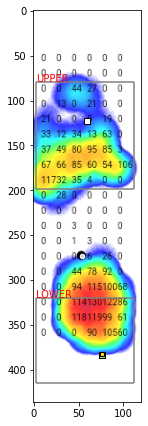

In [39]:
# View a random prediction in training data
print(len(batch['file_name']))
i = 0
img_name = batch['file_name'][i]
print(img_name)
print(df[df.images == img_name])
img_annotation = annotation_df[annotation_df.images == img_name].to_dict('records')[0]
print(pred[i])
show_foot(
    io.imread(Path('train_images') / img_name), 
    annotations = img_annotation,
    black_dot = img_annotation,
    split_crop = split_crop,
    predictions = pred[i]
    )


In [40]:
# predict lower foot for test dataset
my_pred_lower_test = dict()
for i, batch in enumerate(dm.test_dataloader()):
    image_lower = batch['image']['lower'].to(device)
    dot = batch['dot'].to(device)

    outputs = my_model_lower(image_lower, dot)
    pred = [interpret_output({'upper': None, 'lower': (x[0], x[1])}) for x in outputs.data.to('cpu').tolist()]
    my_pred_lower_test.update({f: {'pred_lower_x': pred[idx]['lower'][0], 'pred_lower_y': pred[idx]['lower'][1]} for idx, f in enumerate(batch['file_name'])})

In [41]:
# update test dataset
df = dm.test_dataset.annotation_df.copy()
df['pred_lower_x'] = [my_pred_lower_test[f]['pred_lower_x'] for f in df['images']]
df['pred_lower_y'] = [my_pred_lower_test[f]['pred_lower_y'] for f in df['images']]
print(df.tail())
dm.test_dataset.add_pred_lower(df)

             images  dot_x  dot_y  pred_lower_x  pred_lower_y
995  image_0996.png     67    238       39.0998      362.0266
996  image_0997.png     54    263       79.0246      382.1481
997  image_0998.png     65    253       28.5796      381.0147
998  image_0999.png     56    268       76.1049      380.9322
999  image_1000.png     63    256       36.3968      381.2558


## Upper

In [42]:
class UpperFeetModel(pl.LightningModule):
    
    def __init__(self, learning_rate=LEARNING_RATE):

        super().__init__()
        self.learning_rate = learning_rate

        resnet18_model = models.resnet34(pretrained=False)
        resnet18_conv = nn.Sequential(*list(resnet18_model.children())[:-2])
        self.upper_conv = resnet18_conv 
        self.upper_fc = nn.Sequential(
            nn.Linear((512*4*4+2+2), 512), # resnet18
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def euclidean_distance_loss(self, prediction, ground_truth):
        diff = prediction.view(-1, 2) - ground_truth.view(-1, 2)
        eu_dist = torch.sqrt(torch.sum(torch.pow(diff, 2), dim=1))
        return torch.mean(eu_dist)

    def forward(self, image_upper, dot, pred_lower):
        upper_conv = self.upper_conv(image_upper)
        upper_out = self.upper_fc(torch.cat((self.flatten(upper_conv), dot, pred_lower), 1))
        return upper_out

    def training_step(self, batch, batch_idx):
        image_upper = batch['image']['upper']
        dot = batch['dot']
        annotations_upper = batch['annotations']['upper']
        annotations_lower = batch['annotations']['lower']
        pred_lower = batch['pred_lower']

        RAND_NUM = random.randint(0, 2)
        if RAND_NUM == 0:
            pred_lower = pred_lower
        elif RAND_NUM == 1:
            pred_lower = annotations_lower
        else:
            pred_lower = (pred_lower+annotations_lower)/2

        # Forward pass
        outputs = self.forward(image_upper, dot, pred_lower)
        loss = self.euclidean_distance_loss(outputs, annotations_upper)

        self.log('train_loss', loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        image_upper = batch['image']['upper']
        dot = batch['dot']
        annotations_upper = batch['annotations']['upper']
        pred_lower = batch['pred_lower']

        # Forward pass
        outputs = self.forward(image_upper, dot, pred_lower)
        loss = self.euclidean_distance_loss(outputs, annotations_upper)
        self.log('val_loss', loss, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)
        # return [optimizer], [scheduler]
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [43]:
TRAIN_UPPER = True
MODEL_SAVE_NAME = 'my_upper_feet_model_weights'

# dm = FeetDataModule() 
# datamodule 就用之前的 dm
UPPER_REMOVE_FILE_LIST = {'image_0478.png', 'image_0633.jpg', 'image_0663.jpg', 'image_0623.jpg', 'image_0652.jpg', 
                          'image_0888.png', 'image_0170_1.jpg', 'image_0609.jpg', 'image_0331_1.jpg', 'image_0359_1.jpg'}

dm.all_train_dataset.update_file_removal(UPPER_REMOVE_FILE_LIST)
dm.train_dataset.update_file_removal(UPPER_REMOVE_FILE_LIST)
dm.val_dataset.update_file_removal(UPPER_REMOVE_FILE_LIST)
dm._modify_batch_size()
print(f"batch_size: {dm.batch_size}")

model_upper = UpperFeetModel()

if TRAIN_UPPER:
    logger = TensorBoardLogger('tb_logs', name='my_upper_feet_model')
    early_stop_callback = EarlyStopping(
        min_delta=0.00,
        patience=6,
        verbose=False,
        monitor='val_loss',
        mode='min'
    )
    checkpoint_callback = ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename=MODEL_SAVE_NAME,
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    trainer = pl.Trainer(max_epochs=50, 
                        logger=logger, 
                        progress_bar_refresh_rate=20, 
                        gpus=-1 if torch.cuda.is_available() else 0, 
                        auto_lr_find=True,
                        callbacks=[early_stop_callback, checkpoint_callback])
    # trainer.tune(model_upper, dm)
    trainer.fit(model_upper, dm)
    assert checkpoint_callback.best_model_score.item() < 0.062
    model_upper = UpperFeetModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
else:
    print(f"Reuse model: {str(MODEL_SAVE_PATH / MODEL_SAVE_NAME)+'.ckpt'}")
    model_upper = UpperFeetModel.load_from_checkpoint(str(MODEL_SAVE_PATH / MODEL_SAVE_NAME)+'.ckpt')
model_upper.eval()
assert model_upper.training is False

batch_size: 65


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /content/gdrive/MyDrive/aidea_aso_model exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | upper_conv | Sequential | 21.3 M
1 | upper_fc   | Sequential | 4.3 M 
2 | flatten    | Flatten    | 0     
------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.211   Total estimated model params size (MB)


Epoch 0, global step 17: val_loss reached 0.16212 (best 0.16212), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 1, global step 35: val_loss reached 0.08507 (best 0.08507), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 2, global step 53: val_loss reached 0.07877 (best 0.07877), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 3, step 71: val_loss was not in top 1


Epoch 4, step 89: val_loss was not in top 1


Epoch 5, global step 107: val_loss reached 0.06905 (best 0.06905), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 6, step 125: val_loss was not in top 1


Epoch 7, step 143: val_loss was not in top 1


Epoch 8, global step 161: val_loss reached 0.06534 (best 0.06534), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 9, step 179: val_loss was not in top 1


Epoch 10, global step 197: val_loss reached 0.06137 (best 0.06137), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 11, step 215: val_loss was not in top 1


Epoch 12, step 233: val_loss was not in top 1


Epoch 13, step 251: val_loss was not in top 1


Epoch 14, step 269: val_loss was not in top 1


Epoch    15: reducing learning rate of group 0 to 5.0000e-05.


Epoch 15, step 287: val_loss was not in top 1


Epoch 16, global step 305: val_loss reached 0.06076 (best 0.06076), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 17, global step 323: val_loss reached 0.05738 (best 0.05738), saving model to "/content/gdrive/MyDrive/aidea_aso_model/my_upper_feet_model_weights.ckpt" as top 1


Epoch 18, step 341: val_loss was not in top 1


Epoch 19, step 359: val_loss was not in top 1


Epoch 20, step 377: val_loss was not in top 1


Epoch 21, step 395: val_loss was not in top 1


Epoch    22: reducing learning rate of group 0 to 5.0000e-06.


Epoch 22, step 413: val_loss was not in top 1


Epoch 23, step 431: val_loss was not in top 1


In [44]:
# # Start tensorboard.
# %reload_ext tensorboard
# %tensorboard --logdir tb_logs/

In [45]:
# Check the prediction results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_model_upper = model_upper.eval().to(device)

def _eu_dist_loss(prediction, ground_truth):
    diff = prediction.view(-1, 2) - ground_truth.view(-1, 2)
    eu_dist = torch.sqrt(torch.sum(torch.pow(diff, 2), dim=1))
    return eu_dist

# predict upper foot for all train dataset
my_pred_upper_train = dict()
for i, batch in enumerate(dm.all_train_dataloader()):
    image_upper = batch['image']['upper'].to(device)
    dot = batch['dot'].to(device)
    pred_lower = batch['pred_lower'].to(device)
    annotations_upper = batch['annotations']['upper'].to(device)

    outputs = my_model_upper(image_upper, dot, pred_lower)
    loss = _eu_dist_loss(outputs, annotations_upper).data.to('cpu').tolist()
    pred = [interpret_output({'upper': (x[0], x[1]), 'lower': None}) for x in outputs.data.to('cpu').tolist()]
    my_pred_upper_train.update({f: {'pred_upper_x': pred[idx]['upper'][0], 
                                    'pred_upper_y': pred[idx]['upper'][1],
                                    'loss': loss[idx]} for idx, f in enumerate(batch['file_name'])})

In [46]:
# predict upper foot for test dataset
my_pred_upper_test = dict()
for i, batch in enumerate(dm.test_dataloader()):
    image_upper = batch['image']['upper'].to(device)
    dot = batch['dot'].to(device)
    pred_lower = batch['pred_lower'].to(device)

    outputs = my_model_upper(image_upper, dot, pred_lower)
    pred = [interpret_output({'upper': (x[0], x[1]), 'lower': None}) for x in outputs.data.to('cpu').tolist()]
    my_pred_upper_test.update({f: {'pred_upper_x': pred[idx]['upper'][0], 'pred_upper_y': pred[idx]['upper'][1]} for idx, f in enumerate(batch['file_name'])})

In [47]:
df = dm.test_dataset.annotation_df.copy()
df['pred_upper_x'] = [my_pred_upper_test[f]['pred_upper_x'] for f in df['images']]
df['pred_upper_y'] = [my_pred_upper_test[f]['pred_upper_y'] for f in df['images']]
print(df.tail())

             images  dot_x  dot_y  ...  pred_lower_y  pred_upper_x  pred_upper_y
995  image_0996.png     67    238  ...      362.0266       60.1573      120.5693
996  image_0997.png     54    263  ...      382.1481       56.6851      134.4048
997  image_0998.png     65    253  ...      381.0147       59.1323      133.4609
998  image_0999.png     56    268  ...      380.9322       58.7979      120.4937
999  image_1000.png     63    256  ...      381.2558       60.0660      120.7972

[5 rows x 7 columns]


In [50]:
# Final prediction and submission
df = dm.test_dataset.annotation_df.copy()
df['pred_upper_x'] = [my_pred_upper_test[f]['pred_upper_x'] for f in df['images']]
df['pred_upper_y'] = [my_pred_upper_test[f]['pred_upper_y'] for f in df['images']]
tmp = pd.read_csv('submission.csv')
assert all([df['images'][i] == tmp['images'][i] for i in random.sample(range(len(df)), 10)])
df = df[['images', 'pred_upper_x', 'pred_upper_y', 'pred_lower_x', 'pred_lower_y']]
df.columns = ['images', 'x1', 'y1', 'x2', 'y2']
print(df.tail())
df.to_csv('my_submission.csv', index=False)

             images       x1        y1       x2        y2
995  image_0996.png  60.1573  120.5693  39.0998  362.0266
996  image_0997.png  56.6851  134.4048  79.0246  382.1481
997  image_0998.png  59.1323  133.4609  28.5796  381.0147
998  image_0999.png  58.7979  120.4937  76.1049  380.9322
999  image_1000.png  60.0660  120.7972  36.3968  381.2558
